In [1]:
import os
import random
import shutil
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D,concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras import regularizers
from keras.utils import plot_model
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Set random seed
random_seed = 42
random.seed(random_seed)

# Set the path to the dataset and output directory
dataset_path = '/kaggle/input/dataset7/Chest x ray datset Version 7/'
output_path = '/kaggle/working/split_dataset/'

# Create train, test, and validation directories
train_path = os.path.join(output_path, 'train')
test_path = os.path.join(output_path, 'test')
val_path = os.path.join(output_path, 'val')

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# List of classes
classes = ['Normal', 
           'Tuberculosis', 
           'covid', 
           'Fibrosis', 
           'Lung opacity','Viral Pneumonia','Bacterial Pneumonia','Pneumothorax']

In [3]:
# Limit the number of images per class to 2690
max_images_per_class = 5000

train_images = []
test_images = []
val_images = []
train_labels = []  # Initialize an empty list for labels

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    images = images[:min(len(images), max_images_per_class)]

    # Shuffle the images to randomize the selection
    random.shuffle(images)

    train_split, test_val_split = train_test_split(images, test_size=0.2, random_state=random_seed)
    test_split, val_split = train_test_split(test_val_split, test_size=0.5, random_state=random_seed)

    # class directories in train, test, and val
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_name), exist_ok=True)

    # Move images to respective directories and assign labels
    for img in train_split:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_path, class_name, img))
        train_labels.append(class_name)  # Assign labels

    for img in test_split:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_path, class_name, img))

    for img in val_split:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_path, class_name, img))

    # Extend the train_images list with resampled images
    train_images.extend(train_split)
    test_images.extend(test_split)
    val_images.extend(val_split)

# Display directory information
for class_name in classes:
    print(f"{class_name} - Train: {len(os.listdir(os.path.join(train_path, class_name)))}, Test: {len(os.listdir(os.path.join(test_path, class_name)))}, Val: {len(os.listdir(os.path.join(val_path, class_name)))}")


Normal - Train: 4000, Test: 500, Val: 500
Tuberculosis - Train: 2800, Test: 350, Val: 350
covid - Train: 2892, Test: 362, Val: 362
Fibrosis - Train: 1348, Test: 169, Val: 169
Lung opacity - Train: 4000, Test: 500, Val: 500
Viral Pneumonia - Train: 3595, Test: 449, Val: 450
Bacterial Pneumonia - Train: 4000, Test: 500, Val: 500
Pneumothorax - Train: 1755, Test: 219, Val: 220


# Augment images

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image

datagen = ImageDataGenerator(
 rotation_range= 30,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=False,
 fill_mode='nearest'
)


def augment_images(original_images_dir, num_images, augmentation_factor):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest'
    )

    image_files = os.listdir(original_images_dir)[:num_images]

    for img_file in image_files:
        img_path = os.path.join(original_images_dir, img_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        for _ in range(augmentation_factor):
            for batch in datagen.flow(x, batch_size=1,
                                      save_to_dir=original_images_dir,
                                      save_prefix='aug',
                                      save_format='png'):
                break


# Example usage
augment_images('/kaggle/working/split_dataset/train/Pneumothorax', 1290, 2)
augment_images('/kaggle/working/split_dataset/train/Fibrosis', 1325, 2)
augment_images('/kaggle/working/split_dataset/train/Tuberculosis', 1280, 1)
augment_images('/kaggle/working/split_dataset/train/Viral Pneumonia', 400, 1)
augment_images('/kaggle/working/split_dataset/train/covid', 1200, 1)

# Display directory information
for class_name in classes:
    print(f"{class_name} - Train: {len(os.listdir(os.path.join(train_path, class_name)))}, Test: {len(os.listdir(os.path.join(test_path, class_name)))}, Val: {len(os.listdir(os.path.join(val_path, class_name)))}")


Normal - Train: 4000, Test: 500, Val: 500
Tuberculosis - Train: 4001, Test: 350, Val: 350
covid - Train: 4014, Test: 362, Val: 362
Fibrosis - Train: 3663, Test: 169, Val: 169
Lung opacity - Train: 4000, Test: 500, Val: 500
Viral Pneumonia - Train: 3989, Test: 449, Val: 450
Bacterial Pneumonia - Train: 4000, Test: 500, Val: 500
Pneumothorax - Train: 4005, Test: 219, Val: 220


In [5]:
augment_images('/kaggle/working/split_dataset/train/Fibrosis', 400, 1)
# Display directory information
for class_name in classes:
    print(f"{class_name} - Train: {len(os.listdir(os.path.join(train_path, class_name)))}, Test: {len(os.listdir(os.path.join(test_path, class_name)))}, Val: {len(os.listdir(os.path.join(val_path, class_name)))}")


Normal - Train: 4000, Test: 500, Val: 500
Tuberculosis - Train: 4001, Test: 350, Val: 350
covid - Train: 4014, Test: 362, Val: 362
Fibrosis - Train: 3974, Test: 169, Val: 169
Lung opacity - Train: 4000, Test: 500, Val: 500
Viral Pneumonia - Train: 3989, Test: 449, Val: 450
Bacterial Pneumonia - Train: 4000, Test: 500, Val: 500
Pneumothorax - Train: 4005, Test: 219, Val: 220


In [6]:
!pip install tensorflow-addons
!pip install keras-cv-attention-models
!pip install -U keras-cv-attention-models
!pip install vit-keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.3/796.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.9 MB/s eta 0:00:00


In [7]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras_cv_attention_models import mobilevit
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import layers, models, Input, Model, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, concatenate

# Set batch size and other parameters
batch_size = 64
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Found 31983 images belonging to 8 classes.
Found 3051 images belonging to 8 classes.
Found 3049 images belonging to 8 classes.


In [8]:
from keras_cv_attention_models import mobilevit
import tensorflow_hub as hub

In [9]:
from tensorflow.keras.applications import EfficientNetB0,ResNet50,DenseNet121,MobileNetV2

# ------------------------model ------------

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.applications import DenseNet121

# Overlapping Patch Embedding (used by Swin Transformer)
def overlapped_patch_embedding(x, patch_size=4, stride=2, projection_dim=64):
    x = layers.Conv2D(projection_dim, patch_size, strides=stride, padding='same')(x)
    x = layers.LayerNormalization()(x)
    return x

# Cross-Stage Partial (CSP) Block
def csp_block(x, filters, kernel_size=3):
    split = tf.split(x, num_or_size_splits=2, axis=-1)
    path1 = layers.Conv2D(filters // 2, kernel_size, padding='same', activation='relu')(split[0])
    path2 = layers.Conv2D(filters // 2, kernel_size, padding='same', activation='relu')(split[1])
    x = layers.Concatenate()([path1, path2])
    x = layers.BatchNormalization()(x)
    return x

# Squeeze-and-Excite (SE) Block
def squeeze_excite_block(x, ratio=4):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)
    x = layers.Multiply()([x, se])
    return x

# Swin Transformer Block
def swin_transformer_block(x, num_heads, projection_dim):
    x_ln = layers.LayerNormalization()(x)
    x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x_ln, x_ln)
    x_add = layers.Add()([x, x_attn])
    
    x_ln2 = layers.LayerNormalization()(x_add)
    x_mlp = layers.Dense(projection_dim * 4, activation='gelu')(x_ln2)
    
    x_add_proj = layers.Dense(projection_dim * 4)(x_add)
    
    return layers.Add()([x_add_proj, x_mlp])

# Depthwise Separable Convolution Block
def depthwise_separable_conv_block(x, filters, kernel_size, strides=1):
    x = layers.SeparableConv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# Simplified MobileViT Block
def mobilevit_block(x, filters, patch_size):
    local_rep = depthwise_separable_conv_block(x, filters, kernel_size=3)
    patch_h, patch_w = patch_size, patch_size
    patches = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size, padding='valid', use_bias=False)(local_rep)
    num_patches = (local_rep.shape[1] // patch_h) * (local_rep.shape[2] // patch_w)
    patches = layers.Reshape((num_patches, filters))(patches)
    x1 = layers.LayerNormalization()(patches)
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=filters)(x1, x1) 
    x1 = layers.Add()([attention_output, patches])
    x1 = layers.LayerNormalization()(x1)
    x = layers.GlobalAveragePooling1D()(x1)
    x = layers.Reshape((1, 1, filters))(x)
    return x

# Combined Hybrid CNN-ViT Model with Synergistic Integration of All Components
def HybridCNNViT(input_shape=(224, 224, 3), num_classes=8):
    inputs = Input(shape=input_shape)

    # CNN Backbone: DenseNet121 for Feature Extraction
    base_model = DenseNet121(include_top=False, input_shape=input_shape, weights="imagenet")
    
    for layer in base_model.layers[:-10]: 
        layer.trainable = False
    
    cnn_features = base_model(inputs)
    cnn_features = depthwise_separable_conv_block(cnn_features, 128, kernel_size=3) 

    # CSP Blocks to Enhance CNN Features
    cnn_path = csp_block(cnn_features, filters=64)  

    # Apply Squeeze-and-Excite after CSP block (CNN features recalibration)
    cnn_path = squeeze_excite_block(cnn_path)

    # Swin Transformer Block
    swin_features = swin_transformer_block(cnn_path, num_heads=2, projection_dim=32) 

    # MobileViT Block
    mobilevit_features = mobilevit_block(inputs, filters=64, patch_size=8)  # Reduced filters and patch size
    mobilevit_features = layers.UpSampling2D(size=(cnn_path.shape[1] // mobilevit_features.shape[1],
                                                   cnn_path.shape[2] // mobilevit_features.shape[2]))(mobilevit_features)

    # Adjust swin_features and mobilevit_features to match channels of cnn_path before merging
    swin_features = layers.Conv2D(64, kernel_size=1, strides=1, padding='same')(swin_features)  # Reduced filters
    mobilevit_features = layers.Conv2D(64, kernel_size=1, strides=1, padding='same')(mobilevit_features)  # Reduced filters

    # Merge Features from CNN, Swin Transformer, and MobileViT
    combined = layers.Add()([cnn_path, swin_features, mobilevit_features])

    # Apply Squeeze-and-Excite after the combined features (Final recalibration)
    combined = squeeze_excite_block(combined)

    # Attention and Classification Head
    x = layers.GlobalAveragePooling2D()(combined)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Reduced units
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the Model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Compile the model
model2 = HybridCNNViT()
model2.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model2.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, 7, 7, 1024)   7037504     ['input_1[0][0]']                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 7, 7, 128)   140288      ['densenet121[0][0]']            
 v2D)                                                                                             
                             

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Define callbacks
checkpoint = ModelCheckpoint('best_model_vit.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)

# Train the model
epochs = 25
history = model2.fit(
    train_generator,
    steps_per_epoch=np.ceil(train_generator.samples / batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=np.ceil(validation_generator.samples / batch_size),
    callbacks=[checkpoint,reduce_lr]
)


Epoch 1/25
500/500 [==============================] - ETA: 0s - loss: 1.0127 - accuracy: 0.7138
Epoch 1: val_accuracy improved from -inf to 0.76237, saving model to best_model_vit.h5
500/500 [==============================] - 378s 695ms/step - loss: 1.0127 - accuracy: 0.7138 - val_loss: 0.7247 - val_accuracy: 0.7624 - lr: 0.0010
Epoch 2/25
500/500 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.8162
Epoch 2: val_accuracy improved from 0.76237 to 0.78401, saving model to best_model_vit.h5
500/500 [==============================] - 337s 674ms/step - loss: 0.4884 - accuracy: 0.8162 - val_loss: 0.6406 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 3/25
500/500 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8452
Epoch 3: val_accuracy improved from 0.78401 to 0.85742, saving model to best_model_vit.h5
500/500 [==============================] - 337s 673ms/step - loss: 0.3956 - accuracy: 0.8452 - val_loss: 0.4006 - val_accuracy: 0.8574 - lr: 0.0010
E

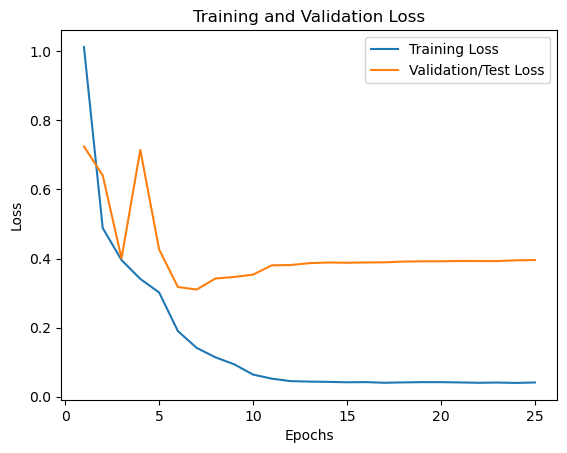

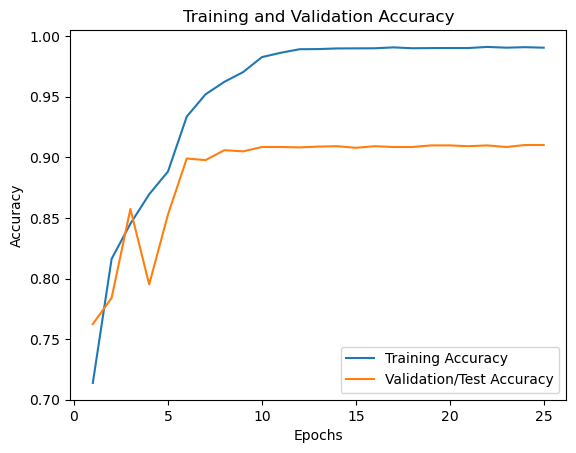

47/47 [==============================] - 20s 426ms/step - loss: 0.3646 - accuracy: 0.9146
Test Loss without loading best weights: 0.3645626902580261
Test Accuracy without loading best weights: 0.9145611524581909
48/48 [==============================] - 25s 483ms/step
Classification Report without loading best weights:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       500
           1       0.66      0.67      0.66       169
           2       0.91      0.91      0.91       500
           3       0.91      0.91      0.91       500
           4       0.77      0.74      0.76       219
           5       0.99      0.99      0.99       350
           6       0.94      0.97      0.95       449
           7       0.97      0.97      0.97       362

    accuracy                           0.92      3049
   macro avg       0.89      0.89      0.89      3049
weighted avg       0.92      0.92      0.92      3049

47/47 [=====================

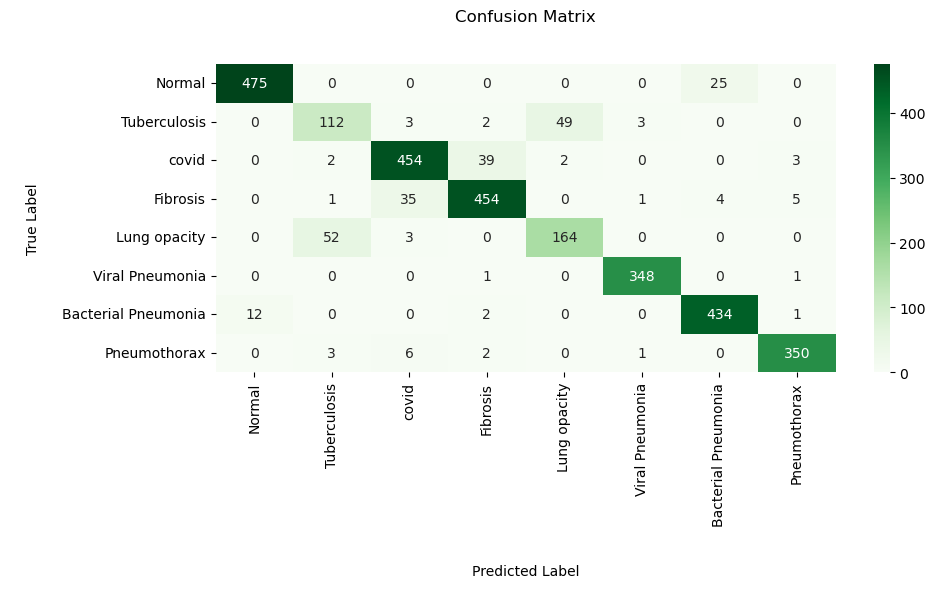

48/48 [==============================] - 20s 411ms/step


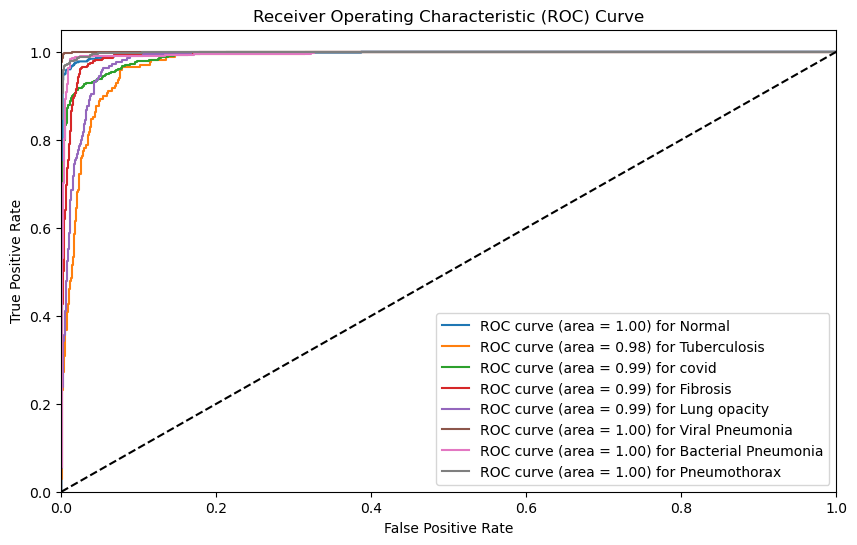

AUC for Normal: 1.00
AUC for Tuberculosis: 0.98
AUC for covid: 0.99
AUC for Fibrosis: 0.99
AUC for Lung opacity: 0.99
AUC for Viral Pneumonia: 1.00
AUC for Bacterial Pneumonia: 1.00
AUC for Pneumothorax: 1.00


In [12]:
import matplotlib.pyplot as plt

history_dict = history.history

# Plotting the loss charts
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('Loss_chart.png')
plt.show()

# Plot the accuracy
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('Accuracy_chart.png')
plt.show()

num_test_samples = len(test_generator)

# Evaluate the model on the test set without loading the best weights
test_results_without_best_weights = model2.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Loss without loading best weights:", test_results_without_best_weights[0])
print("Test Accuracy without loading best weights:", test_results_without_best_weights[1])

# Generate predictions for the model without loading the best weights
predicted_probabilities_without_best_weights = model2.predict(test_generator, steps=num_test_samples)
predicted_labels_without_best_weights = np.argmax(predicted_probabilities_without_best_weights, axis=1)

true_labels = test_generator.classes

# Print classification report for the model without loading the best weights
report_without_best_weights = classification_report(true_labels, predicted_labels_without_best_weights)
print("Classification Report without loading best weights:\n", report_without_best_weights)

# Load the best weights
model2.load_weights('/kaggle/working/best_model_vit.h5')

# Evaluate the model on the test set after loading the best weights
test_results_with_best_weights = model2.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Loss with loaded best weights:", test_results_with_best_weights[0])
print("Test Accuracy with loaded best weights:", test_results_with_best_weights[1])

# Generate predictions for the model with loaded best weights
predicted_probabilities_with_best_weights = model2.predict(test_generator, steps=num_test_samples)
predicted_labels_with_best_weights = np.argmax(predicted_probabilities_with_best_weights, axis=1)

# Print classification report for the model with loaded best weights
report_with_best_weights = classification_report(true_labels, predicted_labels_with_best_weights)
print("Classification Report with loaded best weights:\n", report_with_best_weights)

cm = confusion_matrix(true_labels, predicted_labels_with_best_weights)

# Plotting the confusion matrix heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate predicted probabilities for each class
predicted_probabilities_with_best_weights = model2.predict(test_generator, steps=num_test_samples)

# Compute ROC curve and ROC area for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(test_generator.classes, predicted_probabilities_with_best_weights[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {classes[i]}')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve.png')
plt.show()

# Print AUC for each class
for i in range(len(classes)):
    print(f'AUC for {classes[i]}: {roc_auc[i]:.2f}')

# MODEL 1 - CUSTOM CNN

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Define the Combined Model with MobileViT-XS as feature extractor
def CombinedModel(input_shape=(224, 224, 3), num_classes=8):
    inputs = Input(shape=input_shape)

    # Branch 1
    branch1 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(inputs)
    branch1 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch1)
    branch1 = BatchNormalization()(branch1)
    branch1 = MaxPooling2D(pool_size=(3, 3))(branch1)

    branch1 = Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch1)
    branch1 = Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch1)
    branch1 = BatchNormalization()(branch1)
    branch1 = MaxPooling2D(pool_size=(3, 3))(branch1)

    branch1 = Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch1)
    branch1 = Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch1)
    branch1 = BatchNormalization()(branch1)
    branch1 = MaxPooling2D(pool_size=(3, 3))(branch1)

    branch1 = Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch1)
    branch1 = Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch1)
    branch1 = BatchNormalization()(branch1)

    branch1 = GlobalAveragePooling2D()(branch1)

    # Branch 2
    branch2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(inputs)
    branch2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch2)
    branch2 = BatchNormalization()(branch2)
    branch2 = MaxPooling2D(pool_size=(3, 3))(branch2)

    branch2 = Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch2)
    branch2 = Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch2)
    branch2 = BatchNormalization()(branch2)
    branch2 = MaxPooling2D(pool_size=(3, 3))(branch2)

    branch2 = Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch2)
    branch2 = Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch2)
    branch2 = BatchNormalization()(branch2)
    branch2 = MaxPooling2D(pool_size=(3, 3))(branch2)

    branch2 = Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch2)
    branch2 = Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same')(branch2)
    branch2 = BatchNormalization()(branch2)

    branch2 = GlobalAveragePooling2D()(branch2)

    # Concatenate the outputs of MobileViT and Multi-Scale ViT
    concatenated = layers.Concatenate(axis=-1)([ branch1,branch2])

    # Fully Connected Layers
    #x = layers.Dense(512, activation='relu')(concatenated)
    #x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
    x = layers.Dropout(0.5)(x)
    #x = layers.Dense(128, activation='relu')(concatenated)
    #x = layers.Dropout(0.3)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the combined model
model1 = CombinedModel(input_shape=(224, 224, 3), num_classes=8)

# Model summary
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                           

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)

# Train the model
epochs = 25
history = model1.fit(
    train_generator,
    steps_per_epoch=np.ceil(train_generator.samples / batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=np.ceil(validation_generator.samples / batch_size),
    callbacks=[checkpoint,reduce_lr]
)


Epoch 1/25
500/500 [==============================] - ETA: 0s - loss: 1.3404 - accuracy: 0.7009
Epoch 1: val_accuracy improved from -inf to 0.29531, saving model to best_model.h5
500/500 [==============================] - 338s 649ms/step - loss: 1.3404 - accuracy: 0.7009 - val_loss: 4.0249 - val_accuracy: 0.2953 - lr: 0.0010
Epoch 2/25
500/500 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.7794
Epoch 2: val_accuracy did not improve from 0.29531
500/500 [==============================] - 320s 640ms/step - loss: 0.5552 - accuracy: 0.7794 - val_loss: 5.7321 - val_accuracy: 0.2852 - lr: 0.0010
Epoch 3/25
500/500 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.8027
Epoch 3: val_accuracy did not improve from 0.29531

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 [==============================] - 320s 638ms/step - loss: 0.5009 - accuracy: 0.8027 - val_loss: 5.7939 - val_accuracy: 0.2245 - lr: 0.0010
Epoch

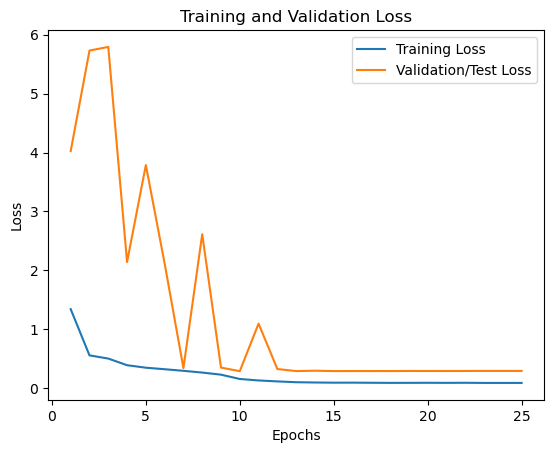

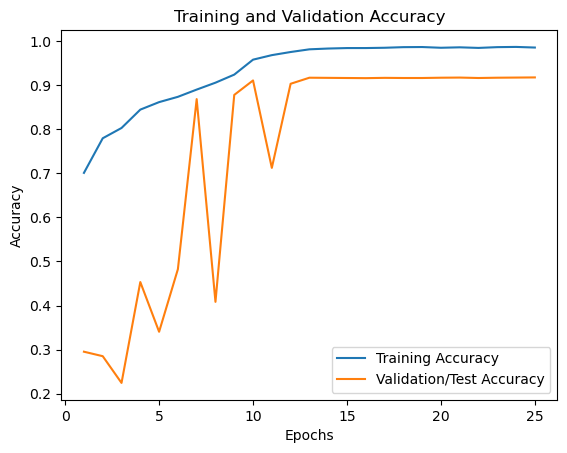

47/47 [==============================] - 19s 398ms/step - loss: 0.3036 - accuracy: 0.9132
Test Loss without loading best weights: 0.3035636246204376
Test Accuracy without loading best weights: 0.913231372833252
48/48 [==============================] - 21s 437ms/step
Classification Report without loading best weights:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       500
           1       0.68      0.66      0.67       169
           2       0.92      0.91      0.92       500
           3       0.91      0.92      0.91       500
           4       0.75      0.76      0.75       219
           5       1.00      1.00      1.00       350
           6       0.94      0.92      0.93       449
           7       0.99      0.98      0.98       362

    accuracy                           0.91      3049
   macro avg       0.89      0.89      0.89      3049
weighted avg       0.91      0.91      0.91      3049

47/47 [======================

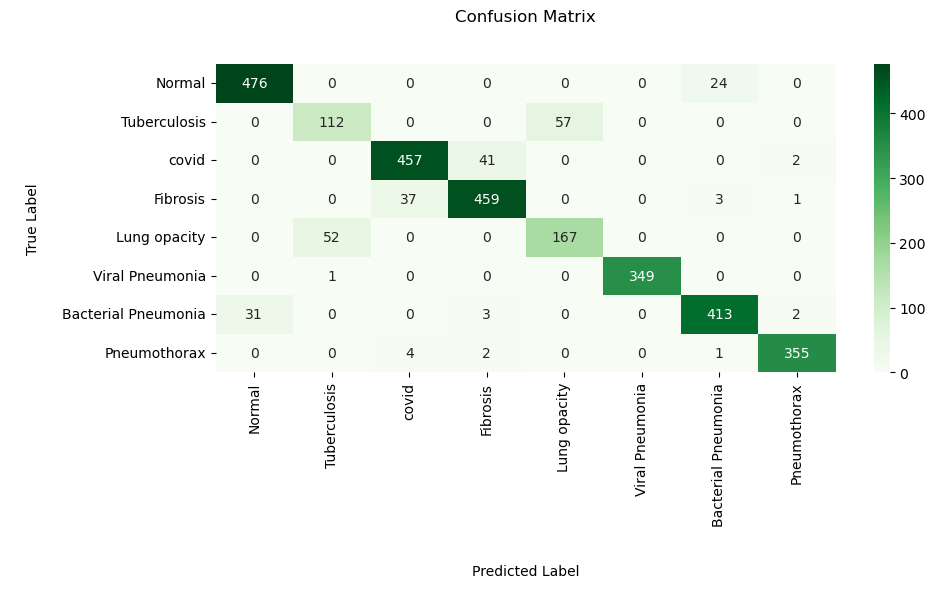

48/48 [==============================] - 19s 385ms/step


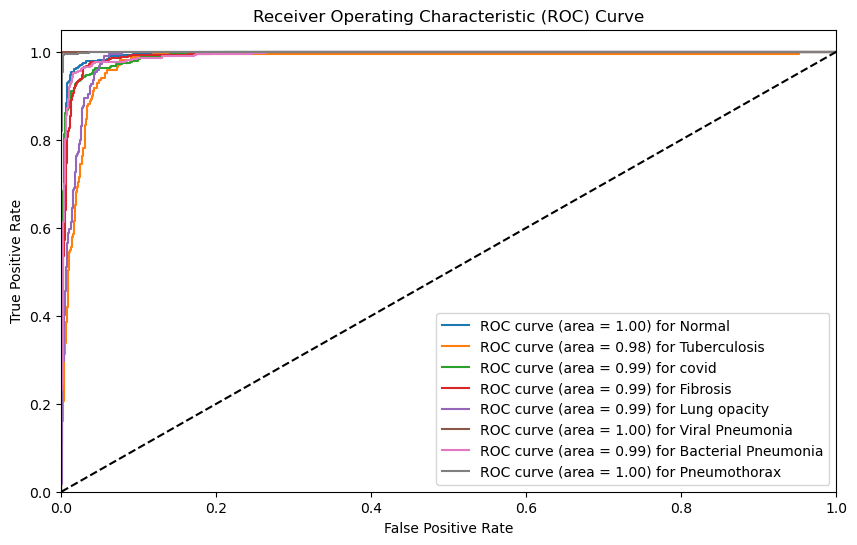

AUC for Normal: 1.00
AUC for Tuberculosis: 0.98
AUC for covid: 0.99
AUC for Fibrosis: 0.99
AUC for Lung opacity: 0.99
AUC for Viral Pneumonia: 1.00
AUC for Bacterial Pneumonia: 0.99
AUC for Pneumothorax: 1.00


In [15]:
import matplotlib.pyplot as plt

history_dict = history.history

# Plotting the loss charts
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('Loss_chart.png')
plt.show()

# Plot the accuracy
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('Accuracy_chart.png')
plt.show()

num_test_samples = len(test_generator)

# Evaluate the model on the test set without loading the best weights
test_results_without_best_weights = model1.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Loss without loading best weights:", test_results_without_best_weights[0])
print("Test Accuracy without loading best weights:", test_results_without_best_weights[1])

# Generate predictions for the model without loading the best weights
predicted_probabilities_without_best_weights = model1.predict(test_generator, steps=num_test_samples)
predicted_labels_without_best_weights = np.argmax(predicted_probabilities_without_best_weights, axis=1)

true_labels = test_generator.classes

# Print classification report for the model without loading the best weights
report_without_best_weights = classification_report(true_labels, predicted_labels_without_best_weights)
print("Classification Report without loading best weights:\n", report_without_best_weights)

# Load the best weights
model1.load_weights('/kaggle/working/best_model.h5')

# Evaluate the model on the test set after loading the best weights
test_results_with_best_weights = model1.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Loss with loaded best weights:", test_results_with_best_weights[0])
print("Test Accuracy with loaded best weights:", test_results_with_best_weights[1])

# Generate predictions for the model with loaded best weights
predicted_probabilities_with_best_weights = model1.predict(test_generator, steps=num_test_samples)
predicted_labels_with_best_weights = np.argmax(predicted_probabilities_with_best_weights, axis=1)

# Print classification report for the model with loaded best weights
report_with_best_weights = classification_report(true_labels, predicted_labels_with_best_weights)
print("Classification Report with loaded best weights:\n", report_with_best_weights)

cm = confusion_matrix(true_labels, predicted_labels_with_best_weights)

# Plotting the confusion matrix heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate predicted probabilities for each class
predicted_probabilities_with_best_weights = model1.predict(test_generator, steps=num_test_samples)

# Compute ROC curve and ROC area for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(test_generator.classes, predicted_probabilities_with_best_weights[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {classes[i]}')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve.png')
plt.show()

# Print AUC for each class
for i in range(len(classes)):
    print(f'AUC for {classes[i]}: {roc_auc[i]:.2f}')


# Ensemble 

In [16]:
from sklearn.metrics import accuracy_score

# Load the models
model1 = keras.models.load_model('/kaggle/working/best_model.h5')
model2 = keras.models.load_model('/kaggle/working/best_model_vit.h5')

# Get predictions from each model
preds1 = model1.predict(test_generator)
preds2 = model2.predict(test_generator)

# Combine predictions
preds = np.array([preds1, preds2])
summed = np.sum(preds, axis=0)

# Argmax across classes to get the final prediction
ensemble_prediction = np.argmax(summed, axis=1)

# Ground truth labels
y_test = test_generator.classes

# Predictions for individual models
prediction1 = np.argmax(preds1, axis=1)
prediction2 = np.argmax(preds2, axis=1)

# Calculate accuracy for each model
accuracy1 = accuracy_score(y_test, prediction1)
accuracy2 = accuracy_score(y_test, prediction2)

# Calculate accuracy for the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for ensemble = ', ensemble_accuracy)

48/48 [==============================] - 23s 425ms/step
Accuracy Score for model1 =  0.9143981633322401
Accuracy Score for model2 =  0.9153820924893408
Accuracy Score for ensemble =  0.9268612659888488
